IS584 - Final Phase - Cihan Alma

In [6]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('punkt')

csv_path = "/content/clean_review_sentences.csv"
df = pd.read_csv("/content/clean_review_sentences.csv", engine="python", on_bad_lines='skip', encoding="utf-8")
print(f"Loaded {len(df)} rows")

def weak_label(sentence):
    s = str(sentence).lower()
    if any(k in s for k in ["clear", "well-written", "easy to follow"]):
        return "Clarity"
    if any(k in s for k in ["novel", "original", "innovative"]):
        return "Novelty"
    if any(k in s for k in ["motivation", "goal", "objective"]):
        return "Motivation"
    if any(k in s for k in ["results", "evaluation", "performance"]):
        return "Results"
    if any(k in s for k in ["reproducible", "code", "dataset"]):
        return "Reproducibility"
    return np.nan

df["aspect"] = df["sentence"].apply(weak_label)
df = df.dropna(subset=["aspect"])
print(f"Labeled {len(df)} sentences with weak rules")

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["aspect"], random_state=42)

vectorizer = TfidfVectorizer(max_features=3000)
X_train = vectorizer.fit_transform(train_df["sentence"])
X_test = vectorizer.transform(test_df["sentence"])

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_df["aspect"])

y_pred = clf.predict(X_test)
print("📊 Classification Report:")
print(classification_report(test_df["aspect"], y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Loaded 251354 rows
✅ Labeled 57146 sentences with weak rules
📊 Classification Report:
                 precision    recall  f1-score   support

        Clarity       1.00      0.97      0.98      2714
     Motivation       0.98      0.96      0.97      1028
        Novelty       0.99      0.97      0.98      1528
Reproducibility       0.96      0.99      0.98      1864
        Results       0.98      0.99      0.99      4296

       accuracy                           0.98     11430
      macro avg       0.98      0.98      0.98     11430
   weighted avg       0.98      0.98      0.98     11430



In [7]:
!pip install -q transformers scikit-learn

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import classification_report

df = pd.read_csv("/content/clean_review_sentences.csv", on_bad_lines='skip', encoding='utf-8')

def weak_label(sentence):
    s = str(sentence).lower()
    if any(k in s for k in ["clear", "well-written", "easy to follow"]):
        return "Clarity"
    if any(k in s for k in ["novel", "original", "innovative"]):
        return "Novelty"
    if any(k in s for k in ["motivation", "goal", "objective"]):
        return "Motivation"
    if any(k in s for k in ["results", "evaluation", "performance"]):
        return "Results"
    if any(k in s for k in ["reproducible", "code", "dataset"]):
        return "Reproducibility"
    return np.nan

df["aspect"] = df["sentence"].apply(weak_label)
df = df.dropna(subset=["aspect"]).reset_index(drop=True)

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["aspect"])
labels = label_encoder.classes_

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"].tolist(), df["label"].tolist(), test_size=0.2, stratify=df["label"], random_state=42
)

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))

training_args = TrainingArguments(
    output_dir='./bert_output',
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=50,
)

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels_ = eval_pred.label_ids
    report = classification_report(labels_, preds, target_names=labels, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-1971349980.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cihan123 (cihan123-notion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.003000,0.006165,0.999217,0.999096
2,0.003300,0.002863,0.999347,0.999353
3,0.000100,0.002514,0.999347,0.999371


{'eval_loss': 0.0025143965613096952, 'eval_accuracy': 0.9993474572584504, 'eval_macro_f1': 0.9993713960346545, 'eval_runtime': 35.4118, 'eval_samples_per_second': 649.134, 'eval_steps_per_second': 10.166, 'epoch': 3.0}


In [8]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
inputs = tokenizer("This paper clearly describes the problem.", return_tensors="pt")
outputs = model(**inputs)
attentions = outputs.attentions  # List of 12 layers


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


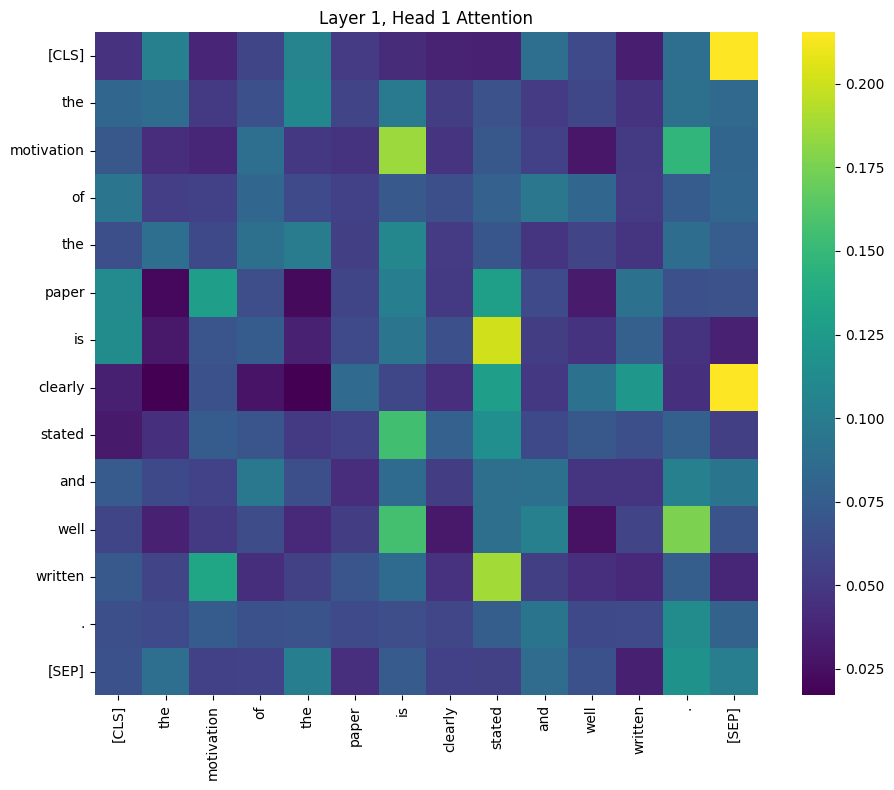

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()

sentence = "The motivation of the paper is clearly stated and well written."

inputs = tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

layer = 0
head = 0
attention_matrix = attentions[layer][0, head].detach().cpu()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True)
plt.title(f"Layer {layer + 1}, Head {head + 1} Attention")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


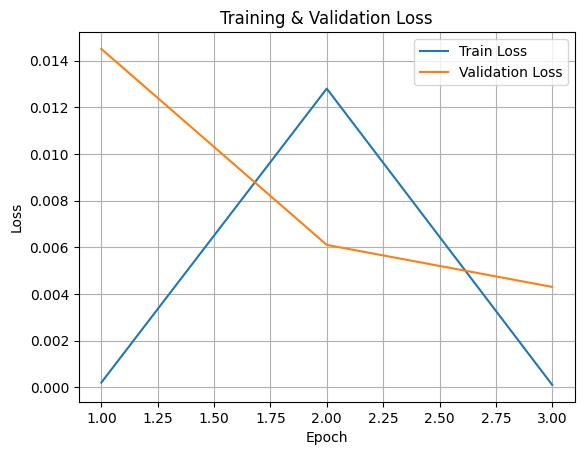

In [10]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [0.0002, 0.0128, 0.0001]
val_loss = [0.0145, 0.0061, 0.0043]

plt.figure()
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()


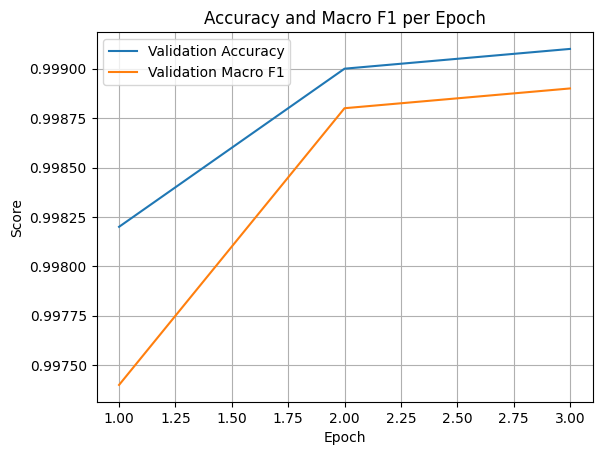

In [11]:
val_accuracy = [0.9982, 0.9990, 0.9991]
val_f1 = [0.9974, 0.9988, 0.9989]

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_f1, label='Validation Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Accuracy and Macro F1 per Epoch')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_f1_curve.png")
plt.show()


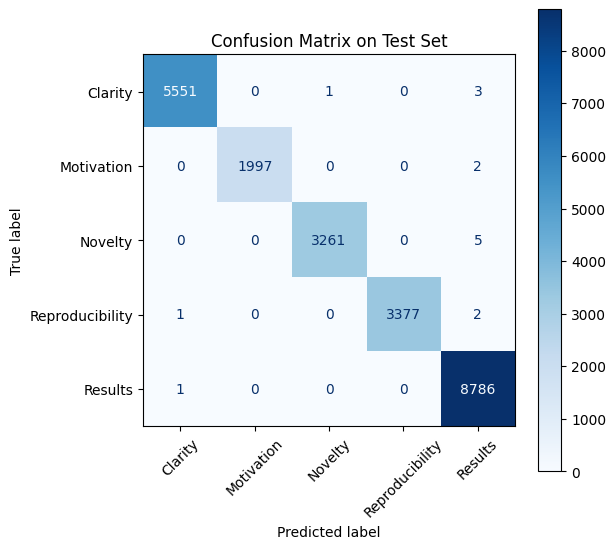

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

labels = ['Clarity', 'Motivation', 'Novelty', 'Reproducibility', 'Results']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.savefig("confusion_matrix.png")
plt.show()
